# Part 3: Reinforcement Learning for Particle Accelerators

In this part of the workshop we will have a look at Reinforcement Learning (RL) and see how to apply it in practice, including a brief example looking at RL for accelerator optimisation.

### Content

 0. Introduction to RL
 1. Practical example of applying RL on the well-known lunar lander task
 2. Practical example of applying RL to a tuning task at the ARES particle accelerator
 3. Further resources

## 0. Introduction to Reinforcement Learning

Reinforcement learning (RL) is a subfield of machine learning (ML), or more specifically a method of training ML models.

The idea of RL is to learn by trial and error, where one wants to perform good actions that give high rewards more often and bad actions that give low rewards less often.

### What can RL do?

Here are some examples of what can be done with RL:

 - Control humanoids in simulation
 - [Play games with imperfect information and develop long-term startegies](https://www.deepmind.com/blog/alphastar-mastering-the-real-time-strategy-game-starcraft-ii)
 - [Control robot hands in the real world](https://openai.com/blog/learning-dexterity/)
 - [Control the plasma in a tokamak fusion reactor](https://www.deepmind.com/blog/accelerating-fusion-science-through-learned-plasma-control)

<div>
    <img src="img/humanoid.gif" width=48%/>
    <img src="img/alphastar.gif" width=48%/>
    <img src="img/learning_dexterity.gif" width=48%/>
    <img src="img/magnetic_plamsa_control.gif" width=48%/>
</div>


### Key Concepts of RL

At the heart of RL is the RL loop shown below that illustrates the relationships and interactions between entities in RL.

<img src="img/rl_loop.jpg" width="65%"/>

The following are the key entities and concepts in RL:

 - The **environment** is the world that the RL agent lives in and interacts with. It may be something as simple as the simulation of a robot or something more complex like a particle accelerator in the real world.
 - **Actions** are how the RL agent interacts with the environment. The can either be discrete (e.g. pressing any of a limited number of buttons) or continuous (setting a limited number of actuators to a certain value).
 - **Observations** determine how the agent sees the environment. This may, for example, be an image from a camera or the measured values from a number of sensors.
 - The **state** of the environment is not always fully observed via the observations. In that case, we speak of a partially-observable environment (POMDP).
 - The **reward** is returned by the environment after each action. And describes the goodness of that action.
 - The **return** is the cummulative reward over time. The goal of RL is to maximise the return.
 - The agent uses a function called **policy** to compute the next action from an observation. Finding the optimal policy of RL that maximises the return is the goal of RL. When talking about RL, we often look at deep RL, where an artificial neural network (ANN) is uses to approximate the optimal policy.

 ### Algorithms

RL is a very wide field where many very different approaches can be used to solve the problem of maximising returns. In this notebook we focus on model-free RL using a *Policy Optimisation* algorithm. This means that our agent is some function with unknown parmeters and through trial-and-error we attempt to optimise the parameters of this function with the objective of maximising the return when we use this function to compute actions for our problem.

While any function may be used, *Artificial Neural Networks* (ANN) have proven to be powerful function approximators that are - in theory - capable of approximating any optimal policy.

Two alternative approaches to Policy Optimisation that are worth mentioning, are the following:
 - **Q-Learning:** Here, the goal is to find a function (called Q-function) that tells us the future return for every action we can perform in a certain state. Assuming we have this function, the optimal policy is simply to choose the action with the highest future return. In *Deep Q-Learning* (DQN) an ANN is used to approximate the Q-function.
 - **Model-based RL:** Here, the agent uses a model - pre-existing or learning - to help guide decisions. One might, for example, use an ANN to learn to predict future states of the environment and then use the trained ANN to plan the next steps such that it will lead to a trajectory that maximises the return.

Note that the distinction between all the types of algorithms in RL is often blurred and many algorithms apply multiple approaches in some way. Understanding, what approaches an algorithm is using, will help you understand their advantages (and disadvantages) and guide you when choosing an algorithm. To give you some overview, below is a non-exhaustive taxonomy of some currently popular algorithms in RL (source [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)).

 <img src="img/rl_taxonomy.png" width="65%"/>

## 1. Lunar Lander Example

In this example, we will train an RL agent on the popular *Lunar Lander* environment. We will be using an implementation of the on-policy algorithm [Proximal Policy Optimisation (PPO)](https://spinningup.openai.com/en/latest/algorithms/ppo.html) provided by the Stable Baselines3 library.

The goal in this task is to savely land a lunar lander on the moon, ideally on a landing pad at position (0,0) in the randomly generated lunar landscape.

### Action

The agent can control the lunar lander by firing the main engine and two thrusters, one on each side of the lander.

### Observation

The agent can observe the lander's position and velocity in x and y, the landars orientation angle and angular velocity as well as whether the lander's legs are currently touching the ground.

### Reward

The lander receives negative rewards for moving away from the landing pad. Crashing is punished with a reward of -100. For each leg touching the ground, the lander receives +10 reward. When coming to rest anywhere on the ground, the lander receives +100 points. When coming to rest on the landing pad, the lander receives +200 points. Using fuel gives negative reward with the main engine costing -0.3 when fired and the side thrusters costing -0.03 when fired.

In [1]:
# Imports

import gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv

from utils.rl.helpers import make_lunar_lander_training_gifs, plot_lunar_lander_training_history

First we need to create the environment. Environments contained in *Gym* can be created by running

```python
env = gym.make("LunarLander-v2")
```

with the environment's name. In order to facilitate faster training using multiple CPU cores, we use a so-called *vectorised environment*, where multiple of the same environment run in parallel. *Stable Baselines3* offers a convenience function `make_vec_env` to create vectorised versions of Gym environments.

In [2]:
venv = make_vec_env("LunarLander-v2", n_envs=16, vec_env_cls=SubprocVecEnv, monitor_dir="utils/rl/lunar_lander/monitors")

Then we create our PPO agent. These objects are the key component of Stable Baselines3 and contain the implementations of the RL algorithms as well as other utilities to handle inference, model saving and more.

The agent is configured to use a multi-layer perceptron (MLP) as its policy, the previously created environment for training and a number of known-to-work-well hyperparameters.

In [3]:
model = PPO("MlpPolicy", env=venv, n_steps=1024, batch_size=64, gae_lambda=0.98, gamma=0.999, n_epochs=4, ent_coef=0.01, verbose=0)

Now we can train. Training length/budget is measured in number of timesteps (interactions with the environment). 1 Million steps is known to work well for this particular example.

In [4]:
checkpoint_callback = CheckpointCallback(save_freq=6250, save_path="utils/rl/lunar_lander/checkpoints")

In [5]:
# Toggle comment to re-run the training (can take very long)
# model.learn(total_timesteps=int(1e6), callback=checkpoint_callback)

Let's checkout how the episode reward and episode length developed throughout the training.

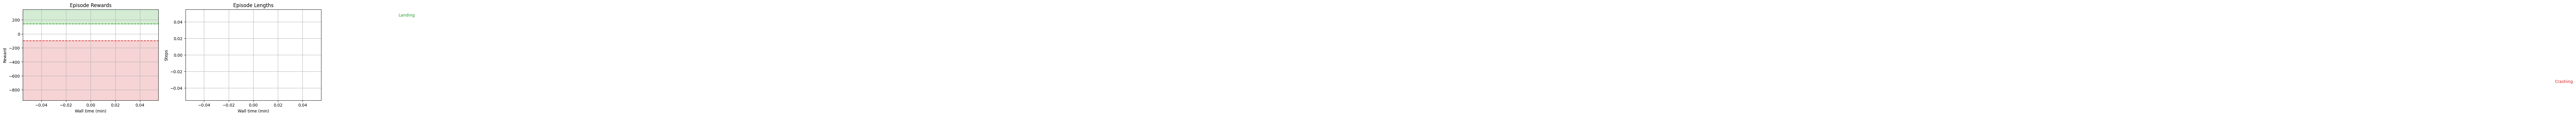

In [6]:
plot_lunar_lander_training_history()

We can also look at the agent trying to land the lunar lander at different stages of the training.

In [7]:
make_lunar_lander_training_gifs()

<div>
    <img src="img/lunar_lander_trainig_100000_steps.gif" width=33%/>
    <img src="img/lunar_lander_trainig_300000_steps.gif" width=33%/>
    <img src="img/lunar_lander_trainig_1000000_steps.gif" width=33%/>
</div>

Now we can load the trained model and try it.

In [8]:
loaded_model = PPO.load("utils/rl/lunar_lander/checkpoints/rl_model_1000000_steps")
env = gym.make("LunarLander-v2")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
env.close()

## 2. Reinforcement Learning for Particle Accelerators

In much the same way we just used RL to train an agent to land a lunar lander, we can also train agents to control particle accelerators. We will take a look at an example close to [one of our papers](https://proceedings.mlr.press/v162/kaiser22a.html).

The goal is to tune the magnets of a section of the accelerator such that we achieve certain beam parameters on a diagnostic screen. Below you can see what the RL loop would look like for this example.

<img src="img/ares_ea_rl_loop.png" width="85%"/>

Because training on the actual accelerator would take too much already scarce beam time, we want to train the RL agent using a simulation. After training the agent must then be able to also work on the real accelerator.

### Technical Setup

The first step in using RL on accelerators is to implement an environment that implements your problem. The environment needs to take actions and set them on the acceleator, for example by writing magnet settings to the control system. It also needs to return observations to the agent by reading (and post-processing) sensor values from the control system as well as compute a reward from the state of the accelerator.

Because we use Gym to implement the environment, existing implementations of RL algorithms can easily be used to train a policy on the accelerator problem.

Two problems with RL on particle accelerators in particular are the sparcity of beam time and the issue of machine safety during training. An straight-forward way to solve these problems is to create a second environment that follows the same logic as the real accelerator, takes in the same actions and provides the same observations and rewards. Using this environment, we can train a policy without requiring beam time or risking the safety of our machine. Then we can exchange the environment and run the trained agent on the real accelerator.

<img src="img/ares_ea_rl_technical_setup.png" width="85%"/>

### Example

Below we demonstrate our code for training and using an RL agent for optimising the ARES Experimental Area.

We do, however, keep it high-level. If you are interested in implementation details, you may check out the included source files.

In [9]:
from time import sleep

import numpy as np

from utils.rl.ea_train import train as train_ares_ea
from utils.rl.ea_train import make_env, read_from_yaml
from utils.rl.helpers import make_ares_ea_training_videos, NotVecNormalize, plot_ares_ea_training_history, show_video

initializing ocelot...


Training a good agent revolves primarily around finding the right setup for the environment and the correct reward function. In order to iterate over and compare many different options, our training function takes a dictionary such as the one below.

Feel free to change things and see how they might affect the final agents.

**Note:** Training this is likely to take at least an hour. The actual function call is therefore commented out and we provide data from a training that we have prepared earlier.

In [10]:
config = {
    "action_mode": "delta",
    "batch_size": 100,
    "gamma": 0.99,
    "filter_action": [0, 1, 3],    # NOTE this training is setup for focusing only
    "filter_observation": None,
    "frame_stack": None,
    "incoming_mode": "random",
    "incoming_values": None,
    "magnet_init_mode": "constant",
    "magnet_init_values": np.array([10, -10, 0, 10, 0]),
    "misalignment_mode": "constant",
    "misalignment_values": np.zeros(8),
    "n_envs": 40,
    "n_steps": 100,
    "normalize_observation": True,
    "normalize_reward": True,
    "rescale_action": (-3, 3),
    "reward_mode": "feedback",
    "sb3_device": "auto",
    "target_beam_mode": "constant",
    "target_beam_values": np.zeros(4),
    "target_mu_x_threshold": np.inf,
    "target_mu_y_threshold": np.inf,
    "target_sigma_x_threshold": 1e-4,
    "target_sigma_y_threshold": 1e-4,
    "total_timesteps": int(2e6),
    "threshold_hold": 5,
    "time_limit": 25,
    "vec_env": "subproc",
    "w_done": 10.0,
    "w_mu_x": 0.0,
    "w_mu_x_in_threshold": 0.0,
    "w_mu_y": 0.0,
    "w_mu_y_in_threshold": 0.0,
    "w_on_screen": 0.0,
    "w_sigma_x": 1.0,
    "w_sigma_x_in_threshold": 0.0,
    "w_sigma_y": 1.0,
    "w_sigma_y_in_threshold": 0.0,
    "w_time": 0.0,
}

# Toggle comment to re-run the training (can take very long)
# train_ares_ea(config)

As before we can look at the training metrics and check out videos taken at different stages of the training ...

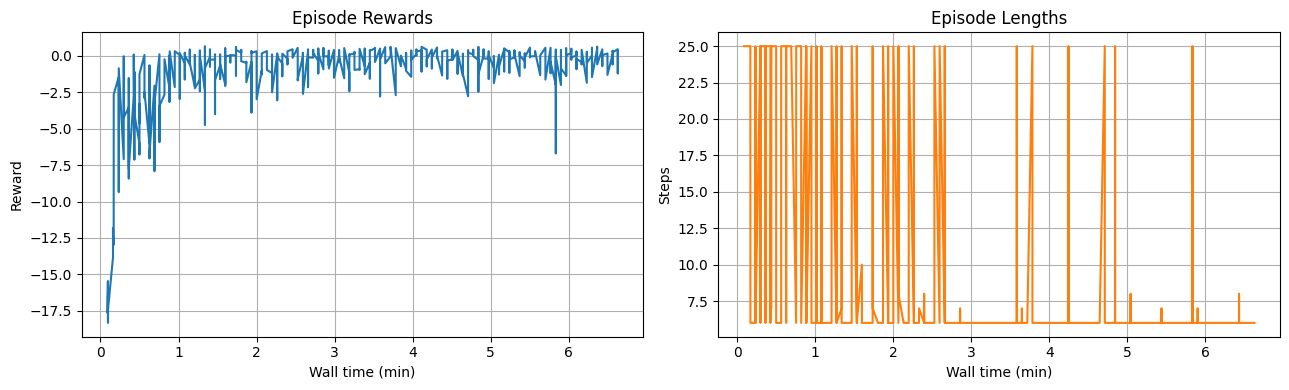

In [11]:
# Training curves from this training
plot_ares_ea_training_history()

... and look at the agent optimising the EA at different stages of training.

In [12]:
make_ares_ea_training_videos()

<div>
    <img src="img/ares-ea-rl-video-episode-0.gif" width=33%/>
    <img src="img/ares-ea-rl-video-episode-27.gif" width=33%/>
    <img src="img/ares-ea-rl-video-episode-343.gif" width=33%/>
</div>

We can also test the trained agent on a simulation.

In [13]:
# Run final agent

loaded_model = PPO.load("utils/rl/ares_ea/models/ml_workshop/model")
loaded_config = read_from_yaml("utils/rl/ares_ea/models/ml_workshop/config")

env = make_env(loaded_config)
env = NotVecNormalize(env, "utils/rl/ares_ea/models/ml_workshop/normalizer")

done = False
observation = env.reset()
while not done:
    action, _ = loaded_model.predict(observation)
    observation, reward, done, info = env.step(action)
    env.render()
    sleep(0.5)
env.close()

### Running in the real world

Below you can see one of our final trained agents optimising position and focus of the beam on the real ARES accelerator.

Keep in mind that this agent has never seen the real accelerator before. All it has ever seen is a very simple linear beam dynamics simulation. Despite that it performs well on the real accelerator where all kinds of other effects come into the mix.

Note that this does not happen by itself and is the result of various careful decisions when designing the traiing setup.

Once trained, the agent is, however, trivial to use and requires no futher tuning or knowledge of RL.

In [14]:
# Show polished donkey running (on real accelerator)
show_video("utils/rl/rl-video-episode-1727.mp4")

## Further Resources

### Getting started in RL
 - [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/index.html) - Very understandable explainations on RL and the most popular algorithms acompanied by easy-to-read Python implementations.
 - [Reinforcement Learning with Stable Baselines 3](https://youtube.com/playlist?list=PLQVvvaa0QuDf0O2DWwLZBfJeYY-JOeZB1) - YouTube playlist giving a good introduction on RL using Stable Baselines3.
 - [Build a Doom AI Model with Python](https://youtu.be/eBCU-tqLGfQ) - Detailed 3h tutorial of applying RL using *DOOM* as an example.
 - [An introduction to Reinforcement Learning](https://youtu.be/JgvyzIkgxF0) - Brief introdution to RL.
 - [An introduction to Policy Gradient methods - Deep Reinforcement Learning](https://www.youtube.com/watch?v=5P7I-xPq8u8) - Brief introduction to PPO.

### Papers

 - [Learning-based optimisation of particle accelerators under partial observability without real-world training](https://proceedings.mlr.press/v162/kaiser22a.html) - Tuning of electron beam properties on a diagnostic screen using RL.
 - [Sample-efficient reinforcement learning for CERN accelerator control](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.23.124801) - Beam trajectory steering using RL with a focus on sample-efficient training.
 - [Autonomous control of a particle accelerator using deep reinforcement learning](https://arxiv.org/abs/2010.08141) - Beam transport through a drift tube linac using RL.
 - [Basic reinforcement learning techniques to control the intensity of a seeded free-electron laser](https://www.mdpi.com/2079-9292/9/5/781/htm) - RL-based laser alignment and drift recovery.
 - [Real-time artificial intelligence for accelerator control: A study at the Fermilab Booster](https://journals.aps.org/prab/abstract/10.1103/PhysRevAccelBeams.24.104601) - Regulation of a gradient magnet power supply using RL and real-time implementation of the trained agent using field-programmable gate arrays (FPGAs).
 - [Magnetic control of tokamak plasmas through deep reinforcement learning](https://www.nature.com/articles/s41586-021-04301-9) - Landmark paper on RL for controling a real-world physical system (plasma in a tokamak fusion reactor).

### Literature
 
 - [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html) - Standard text book on RL.

### Packages
 - [Gym](https://www.gymlibrary.ml) - Defacto standard for implementing custom environments. Also provides a library of RL tasks widely used for benchmarking.
 - [Stable Baslines3](https://github.com/DLR-RM/stable-baselines3) - Provides reliable, benchmarked and easy-to-use implementations of the most important RL algorithms.
 - [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html) - Part of the *Ray* Python package providing implementations of various RL algorithms with a focus on distributed training.